# IDENTIFICANDO FRAUDE NO EMAIL DA ENRON - MACHINE LEARNING

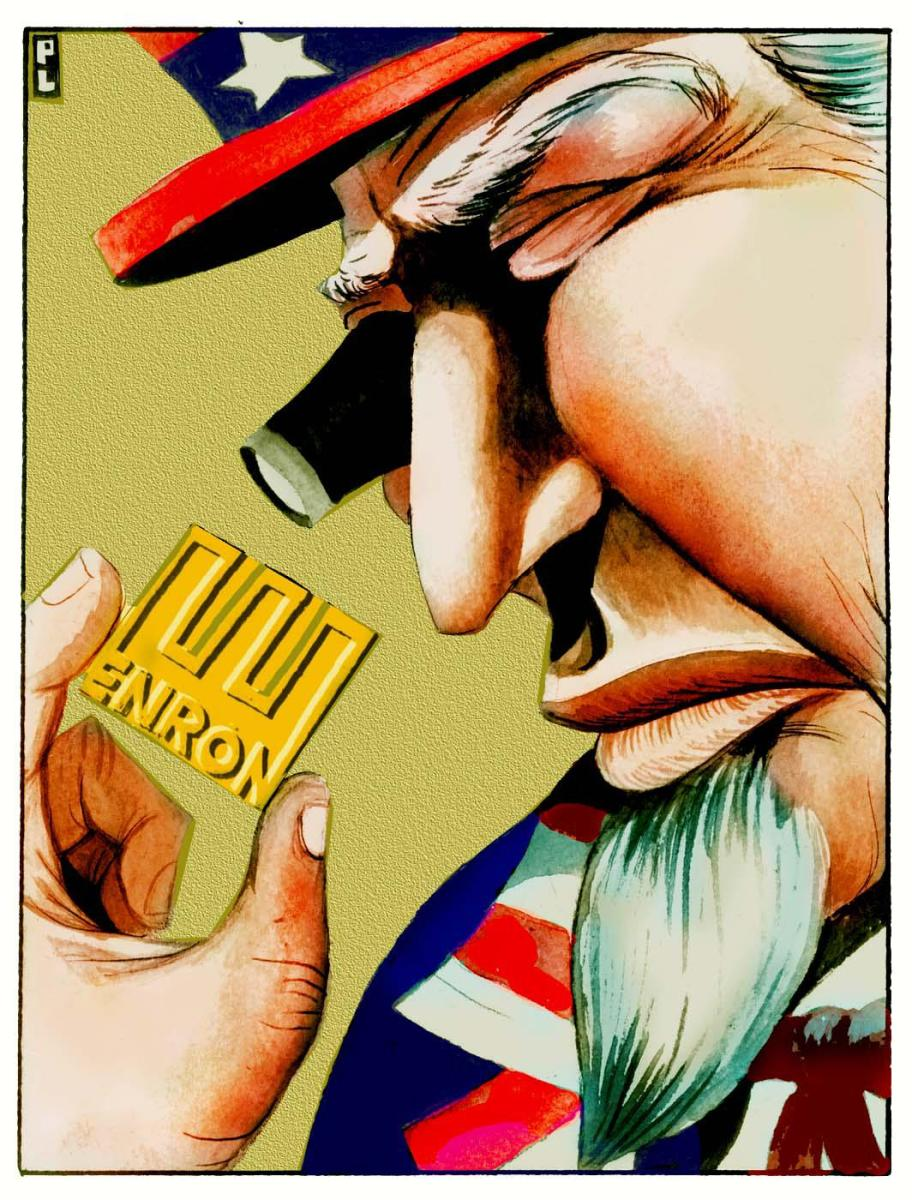

In [1]:
from IPython.display import Image
Image(filename='enron.jpg')

# Introdução

A Enron Corporation foi uma companhia de energia americana, localizada em Houston, Texas. Empregava cerca de 21 000 pessoas, tendo sido uma das empresas líderes no mundo em distribuição de energia (electricidade, gás natural) e comunicações (Wikipédia). Em meados de 2000, a Enron era uma das maiores empresas nos Estados Unidos, em 2002 entrou em falência, devido uma fraude corporativa generalizada e um dos maiores escândalos de corrupção da história americana. Na investigação federal resultante, houve uma quantidade significativa de informações tipicamente confidenciais inseridas no registro público, incluindo dezenas de milhares de e-mails e dados financeiros detalhados para os principais executivos.

# Visão Geral do Projeto

__Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?__

Primeiramente, é interessante mencionar que o dataset deste projeto possui um problema sério cohecido como Data leakage e por definição isso ocorre quando é vazado qualquer informação do dataset de teste para o de treino, como já sabemos quem são os POIs acabamos enviesando totalmente o dataset de treino com as features, porém, nada impede que o trabalho seja feito.

Neste projeto, construirei um identificador de _Person of Interest_ (POI) com base em dados financeiros e de e-mails tornados públicos como resultado do escândalo da Enron. Usarei dados eletrônicos e financeiros para 146 executivos da Enron. Este notebook documenta as técnicas de aprendizado da máquina usadas na construção de um identificador.

**Carregando pacotes e dados**

In [1]:
# Importar pasta do projeto final
import os
os.chdir('C:/Users/Lourdes/Downloads/Intro ML/ud120projects/final_project/')

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import cPickle as pickle
import seaborn as sns

from time import time
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

sys.path.append("C:/Users/Lourdes/Downloads/Intro ML/ud120projects/tools/")

# Importar arquivos externos como o tester.py
from tester import dump_classifier_and_data, test_classifier, main
from feature_format import featureFormat
from feature_format import targetFeatureSplit

%matplotlib inline
pd.set_option('display.max_columns', None)

### Load - dicionário contendo o dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
# Dicionário para dataframe
data_df = pd.DataFrame.from_dict(data_dict, orient='index')

# Primeiro convertemos os NaN para o padrão numpy
data_df.replace('NaN', np.nan, inplace = True)

# Features_list é uma lista de strings - cada uma é um nome de função
# primeiro recurso - "poi" - que será identificado como o rótulo
#features_list = ["poi"]

C:\Users\Lourdes\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Lourdes\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


**Verificando as dimensões de base**

In [2]:
data_df.shape

(146, 21)

São 21 variáveis em colunas de 146 funcionários. 

**Variáveis e seus nomes**

Visualizaremos todos os nomes da variáveis.

In [3]:
all_features = []
c = 0
for key in data_dict:
    if c < 1:
        for feature in data_dict[key]:
            all_features.append(feature)
        c += 1
print "Variáveis: \n{}".format(all_features)

Variáveis: 
['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


**Funcionários classificados como POI**

In [4]:
poi = 0
for key in data_dict:
    if data_dict[key]['poi'] == 1:
        poi += 1
print poi

18


Sabemos que são 18 funcionários classificados como Pessoa de Interesse e a tabela abaixo nos mostrará quais são.

In [5]:
data_df[data_df.poi==True]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
BELDEN TIMOTHY N,213999.0,7991.0,2144013.0,5501630.0,953136.0,5249999.0,157569.0,5521.0,NaN,1110705.0,17355.0,NaN,484.0,210698.0,108.0,True,NaN,-2334434.0,NaN,tim.belden@enron.com,228.0
BOWEN JR RAYMOND M,278601.0,1858.0,NaN,2669589.0,NaN,1350000.0,252055.0,1593.0,NaN,252055.0,65907.0,NaN,27.0,1621.0,15.0,True,NaN,-833.0,974293.0,raymond.bowen@enron.com,140.0
CALGER CHRISTOPHER F,240189.0,2598.0,NaN,1639297.0,NaN,1250000.0,126027.0,2188.0,NaN,126027.0,35818.0,NaN,144.0,486.0,25.0,True,NaN,-262500.0,375304.0,christopher.calger@enron.com,199.0
CAUSEY RICHARD A,415189.0,1892.0,NaN,1868758.0,NaN,1000000.0,2502063.0,1585.0,NaN,2502063.0,30674.0,NaN,49.0,307895.0,12.0,True,NaN,-235000.0,350000.0,richard.causey@enron.com,58.0
COLWELL WESLEY,288542.0,1758.0,27610.0,1490344.0,NaN,1200000.0,698242.0,1132.0,NaN,698242.0,16514.0,NaN,40.0,101740.0,11.0,True,NaN,-144062.0,NaN,wes.colwell@enron.com,240.0
DELAINEY DAVID W,365163.0,3093.0,NaN,4747979.0,2291113.0,3000000.0,1323148.0,2097.0,NaN,3614261.0,86174.0,NaN,3069.0,1661.0,609.0,True,NaN,NaN,1294981.0,david.delainey@enron.com,66.0
FASTOW ANDREW S,440698.0,NaN,NaN,2424083.0,NaN,1300000.0,1794412.0,NaN,NaN,1794412.0,55921.0,NaN,NaN,277464.0,NaN,True,NaN,-1386055.0,1736055.0,andrew.fastow@enron.com,NaN
GLISAN JR BEN F,274975.0,873.0,NaN,1272284.0,384728.0,600000.0,393818.0,874.0,NaN,778546.0,125978.0,NaN,16.0,200308.0,6.0,True,NaN,NaN,71023.0,ben.glisan@enron.com,52.0
HANNON KEVIN P,243293.0,1045.0,NaN,288682.0,5538001.0,1500000.0,853064.0,1035.0,NaN,6391065.0,34039.0,NaN,32.0,11350.0,21.0,True,NaN,-3117011.0,1617011.0,kevin.hannon@enron.com,32.0
HIRKO JOSEPH,NaN,NaN,10259.0,91093.0,30766064.0,NaN,NaN,NaN,NaN,30766064.0,77978.0,NaN,NaN,2856.0,NaN,True,NaN,NaN,NaN,joe.hirko@enron.com,NaN


Uma característica ruim deste conjunto de dados é que há muitos valores faltantes. Logo abaixo veremos os nomes e os valores referenciados a eles.

In [6]:
data_df.sort_values(by='total_payments', ascending=False)[data_df.poi==True]['total_payments']

C:\Users\Lourdes\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


LAY KENNETH L           103559793.0
SKILLING JEFFREY K        8682716.0
BELDEN TIMOTHY N          5501630.0
DELAINEY DAVID W          4747979.0
BOWEN JR RAYMOND M        2669589.0
KOPPER MICHAEL J          2652612.0
FASTOW ANDREW S           2424083.0
SHELBY REX                2003885.0
CAUSEY RICHARD A          1868758.0
CALGER CHRISTOPHER F      1639297.0
KOENIG MARK E             1587421.0
COLWELL WESLEY            1490344.0
GLISAN JR BEN F           1272284.0
RIEKER PAULA H            1099100.0
RICE KENNETH D             505050.0
YEAGER F SCOTT             360300.0
HANNON KEVIN P             288682.0
HIRKO JOSEPH                91093.0
Name: total_payments, dtype: float64

Destes, o disparado é o _LAY KENNETH L_, que foi o Chairman Board da empresa, seguido do CEO _SKILLING JEFFREY K_.

**Entre aqueles que não são POI verificaremos os 5 primeiros**

In [7]:
data_df.sort_values(by='total_payments', ascending=False)[data_df.poi==False]['total_payments'].head()

C:\Users\Lourdes\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


TOTAL               309886585.0
FREVERT MARK A       17252530.0
BHATNAGAR SANJAY     15456290.0
LAVORATO JOHN J      10425757.0
MARTIN AMANDA K       8407016.0
Name: total_payments, dtype: float64

Aqui temos uma discrepância, em primeiro vemos o _TOTAL_ como se fosse um funcionário, esta é a primeira variável identificada que será eliminada mais a frente.

**Atributos para as variáveis**

Verificaremos os atributos logo abaixo. 

In [8]:
data_df.count()

salary                        95
to_messages                   86
deferral_payments             39
total_payments               125
exercised_stock_options      102
bonus                         82
restricted_stock             110
shared_receipt_with_poi       86
restricted_stock_deferred     18
total_stock_value            126
expenses                      95
loan_advances                  4
from_messages                 86
other                         93
from_this_person_to_poi       86
poi                          146
director_fees                 17
deferred_income               49
long_term_incentive           66
email_address                111
from_poi_to_this_person       86
dtype: int64

Somente o atributo poi está presente em todos os funcionários da base, em contraste temos a variável __loan_advances__ que só está presente para 4 funcionários.

**Variáveis faltantes para cada funcionário da base**

In [9]:
num_var_func = data_df.isnull().sum(axis=1)
num_var_func.sort_values(ascending=False).head(15)

LOCKHART EUGENE E                20
GRAMM WENDY L                    18
WROBEL BRUCE                     18
WHALEY DAVID A                   18
THE TRAVEL AGENCY IN THE PARK    18
WAKEHAM JOHN                     17
WODRASKA JOHN                    17
CLINE KENNETH W                  17
GILLIS JOHN                      17
SCRIMSHAW MATTHEW                17
SAVAGE FRANK                     17
MENDELSOHN JOHN                  16
YEAP SOON                        16
CHRISTODOULOU DIOMEDES           16
PEREIRA PAULO V. FERRAZ          16
dtype: int64

O funcionário _LOCKHART EUGENE E_ tem 20 variáveis faltantes de um total de 21 variáveis e o o _THE TRAVEL AGENCY IN THE PARK_ não é uma pessoa, aí temos mais duas variáveis, além do _TOTAL_, que deverão ser excluídas.

# Verificar e excluir outliers

Neste ponto será verificado e excluído os possíveis outliers. Irei plotar abaixo usando como variáveis salário e bônus e verificar se os outliers são de fácil visualização.

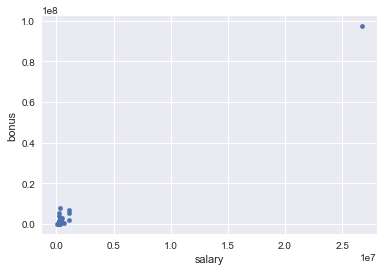

In [10]:
data_df.plot.scatter(x = 'salary', y = 'bonus')

No gráfico vemos um ponto muito fora do conjunto, assim então vamos descobrir quem é o sujeito.

In [11]:
data_df['salary'].idxmax()

'TOTAL'

E o sujeito é o _TOTAL_, como só este apareceu e já foi identificado anteriormente, será removido abaixo.

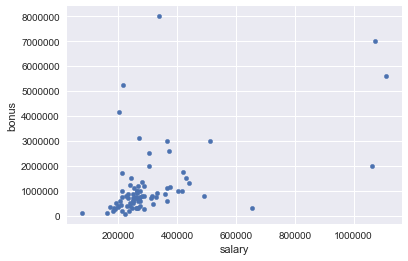

In [12]:
data_df.drop('TOTAL', inplace = True)
data_df.plot.scatter(x = 'salary', y = 'bonus')

Aproveito também para excluir os outros dois outliers importantes já definidos, o _LOCKHART EUGENE E_ e o _THE TRAVEL AGENCY IN THE PARK_.

In [13]:
# Exclusão dos 2 outliers restantes
data_dict.pop('LOCKHART EUGENE E', None)
data_df = data_df.drop(['LOCKHART EUGENE E'])
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', None)
data_df = data_df.drop(['THE TRAVEL AGENCY IN THE PARK'])

__What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.__

# Criar novas características

No conjunto de nossos dados temos a quantidade de e-mails enviados às Pessoas de Interesse (POI) e recebidos dessas Pessoas de Interesse para a maioria dos funcionários. E quanto mais e-mail os funcionários trocam entre si, maior a probabilidade de haverem trocas entre e-mails com as Pessoas de Interesse em questão. Por esse motivo será criado as duas características:

* fração de 'to_messages' recebida de um POI; 

* fração de 'from_messages' enviada para um POI.

Estes podem indicar se a maioria dos e-mails de um funcionário foi trocado com uma Pessoa de Interesse, e serão agrupados em um gráfico de dispersão das duas novas características.

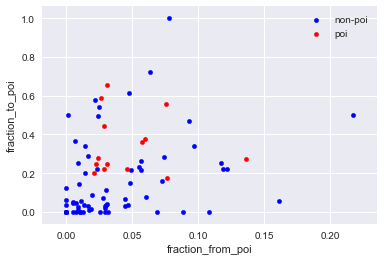

In [14]:
data_df['fraction_from_poi'] = data_df['from_poi_to_this_person'] / data_df['to_messages']
data_df['fraction_to_poi'] = data_df['from_this_person_to_poi'] / data_df['from_messages']

# Gerar scatterplot
ax = data_df[data_df['poi'] == False].plot.scatter(x='fraction_from_poi', y='fraction_to_poi', color='blue', label='non-poi')
data_df[data_df['poi'] == True].plot.scatter(x='fraction_from_poi', y='fraction_to_poi', color='red', label='poi', ax=ax)

E assim temos uma tabela comparativa, exemplificando os resultados obtidos __sem__ e __com__ a utilização das características de engenharia criadas, obtidas através do modelo que me apresentou o melhor desempenho entre todos os testados e usei somente este para tal, Naive Bayes. Estou considerando o escore obtido pelo tester.py

| Novas Características | Accuracy | Precision | Recall | f1 |
| :-----: | :-----: | :-----: |  :-----: |  :-----: |
| *SIM* | 0.84 | 0.40 | 0.33 | 0.36 |
| *NÃO* | 0.86 | 0.45 | 0.45 | 0.42 |

Todos os modelos e resultados encontram-se no final deste notebook.

# Escala de características

Uma padronização dos recursos foi testada para pipeline de classificação para melhorar a pontuação de avaliação dos modelos, a padronização cumpre com o requisito de muitos modelos de aprendizagem de máquinas, que pedem para que os recursos estejam dimensionados.  
Para tal, farei uso do módulo _StandardScaler_ do scikit learn para padronizar os recursos removendo a média e escalando para a variância unitária.

# Selecionar características inteligentes

O segundo passo no pipeline é selecionar as características que mais transmitam informações e deixar algumas para trás seria benéfico, como na redução do ruído na classificação para reduzir o tempo de processamento, uma vez que há menos carcterísticas a se calcular.

O método escolhido foi o _SelectKBest_ do scikit learn usando f_classif como função de pontuação. A função f_classif calcula o valor ANOVA F entre labels e features para tarefas de classificação. Algumas características foram testadas com a ajuda de uma pesquisa em grade (grid search) para o modelo escolhido, Gaussian Naive Bayes. Grid search é basicamente um método de força bruta para estimar hiperparâmetros. Digamos que você tenha k hiperparâmetros e cada um deles possui valores possíveis, então, a realização de pesquisa em grade é basicamente um produto cartesiano desses valores possíveis e teremos x possibilidades (Quora).

As características de maior importância foram geradas de forma decrescente como segue os 10 primeiros abaixo:

* total_stock_value
* exercised_stock_options
* salary
* bonus
* fraction_to_poi
* restricted_stock
* expenses
* shared_receipt_with_poi
* deferred_income
* from_poi_to_this_person

# Escolha de algoritmos

__What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?__

Meu principal algorítmo é o Gaussian Naive-Bayes, pois através deste eu obtive as melhores pontuações na maioria das métricas. Vale ressaltar que em geral quanto maior for o score f1 melhor é o modelo, pois esta métrica indica a qualidade geral do modelo, como tabelado abaixo. 

O algoritmo _tester.py_ é usado para avaliar a performance, precision e recall precisam apresentar ao menos 0.3 de pontuação e o único modelo que chega nessa marca é o Naive-Bayes.  

| Classificadores | Accuracy | Precision | Recall | f1 |
| :-----: | :-----: | :-----: |  :-----: |  :-----: |
| Naive Bayes | 0.84 | 0.40 | 0.33 | 0.36 |
| KMeans | 0.85 | 0.26 | 0.09 | 0.13 |
| AdaBoost | 0.83 | 0.35 | 0.27 | 0.30 |
| Random Forest | 0.86 | 0.42 | 0.16 | 0.23 |


Todos os algoritmos e resultados se encontram no final desta apresentação.

# Afinar o algoritmo

__What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well? How did you tune the parameters of your particular algorithm? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).__

Uma parte crucial da seleção de um algoritmo de aprendizagem de máquina é ajustar seus parâmetros e se não estiverem adequadamente sintonizados, o algoritmo pode se sub-ajustar (underfitting) ou sobre-ajustar (overfitting) aos dados, ocorrendo alto índices de erro.

Para afinar os algoritmos usei a ferramenta GridSearchCV (para o melhor estimador o ".best_estimator") fornecida pelo scikit learn, que busca exaustivamente os melhores parâmetros e combinações entre os especificados, utilizado o cross validation para no final apresentar o melhor score. Os parâmetros são escolhidos para otimizar a função de pontuação escolhida, em nosso caso, o f1 (as métricas de avaliação serão melhor abordadas mais a frente).

# Estratégia de validação

__What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?__

A validação é o processo de aplicação do modelo para uma parte do conjunto de dados, que não foi usada durante o ajuste para avaliar sua capacidade de generalização. Na falta do número necessário de pontos de dados para dividir o conjunto, diversas divisões randomizadas podem ser usadas para a criação e validação do modelo. Um erro clássico é usar os mesmos dados (sem Validação Cruzada) tanto para a criação como para a avaliação, isso leva os modelos a ficarem altamente tendenciosos com desempenho muito fraco em novos pontos de dados.

É uma boa prática separar dados em três partes: treinamento, validação cruzada e conjuntos de teste. O modelo é ajustado para maximizar o escore de avaliação no conjunto de validação cruzada e, em seguida, a eficiência final do modelo é medida no conjunto de teste.

Uma vez que existem poucas observações para treinar e testar os algoritmos para extrair a maior parte da informação dos dados, a estratégia que apliquei para validar o modelo foi a Validação Cruzada _Stratified Shuffle Split_, que é o iterador recomendado para conjuntos de dados com um grande desequilíbrio na distribuição das classes alvo, como é o caso dos e-mails e os dados financeiros em que há um número muito maior de não POI do que de POI. Segundo a definição da documentação do scikit learn, este objeto de validação cruzada é uma fusão de _StratifiedKFold_ e _ShuffleSplit_, que retorna dobras aleatorizadas estratificadas. As dobras são feitas preservando a porcentagem de amostras para cada classe.

Basicamente é usada uma série de train/validation/test. No loop interno, o score é aproximadamente maximizado ajustando o modelo para cada conjunto de treino, e em seguida, maximizado na seleção de hiperparâmetros no conjunto de validação. No loop externo, o erro de generalização é estimado pela média dos scores do conjunto de testes em várias divisões do datasets. Todos os conjuntos são escolhidos aleatoriamente, mas mantendo a mesma proporção de labels de classe.

# Métricas de Avaliação

__Give at least 2 evaluation metrics and your average performance for each of them. Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance.__

* Accuracy: mostra a relação entre classificações corretas e o número total de labels previstos. Uma vez que a distribuição poi/non-poi é bastante desigual, a precisão geral (accuracy) não significa muito. Meu melhor resultado foi de 84%, no qual aparentemente é uma boa pontuação.
* Precision: é a proporção das classificações certas sobre todas as observações com um determinado label previsto. Por exemplo, a proporção de POI's verdadeiros sobre todos os POI's previstos. O melhor resultado foi de 40%.
* Recall: é a proporção das classificações certas sobre todas as observações verdadeiramente de uma determinada classe. Por exemplo, a proporção de observações corretamente identificadas como POI, sobre todos os POI denominados verdadeiros.
* F1: é uma maneira de equilibrar precisão e recall, e é dada pela seguinte fórmula:

 __f1 = 2 x (precision x recall) / (precision + recall)__

As médias dos scores do modelo principal, Naive Bayes, são estas:

| Modelo | Accuracy | Precision | Recall | f1 |
| :-----: | :-----: | :-----: |  :-----: |  :-----: |
| Naive Bayes | 0.84 | 0.40 | 0.33 | 0.36 |

# Modelos

# Opções definidas

A rubrica deste projeto permite avaliar os dados e validar os modelos de duas formas; a primeira opção seria separando o conjunto de dados em dois datasets, um para teste e um para treino, ou segundo opção, em vez de eu ter um conjunto fixo de teste e validação, através da Validação Cruzada _Stratified Shuffle Split_ eu divido o conjunto em 10 grupos (splits), por 10x vezes, dos quais 9 serão usados para treino e 1 será usado para teste. Validação cruzada é uma forma alternativa de validar com relação a forma tradicional de separar em conjuntos de teste e treino definidos. A forma utilizada por mim foi justamente a segunda opção, como podemos verificar abaixo.

In [15]:
### A primeira característica deve ser "poi".
features_list = ['poi', 'salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments',
                 'loan_advances', 'other', 'expenses', 'director_fees', 'total_payments', 
                 'exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 
                 'total_stock_value', 'to_messages', 'from_messages', 'from_this_person_to_poi', 
                 'from_poi_to_this_person', 'shared_receipt_with_poi', 'fraction_from_poi', 'fraction_to_poi']

### Carregar o dicionário contendo o dataset
filled_df = data_df.fillna(value='NaN') # featureFormat expects 'NaN' strings

# De volta ao dict
data_dict = filled_df.to_dict(orient='index')

### Armazenar ao my_dataset para fácil exportar abaixo
my_dataset = data_dict

### Extrair características e labels do dataset para teste
data = featureFormat(my_dataset, features_list, sort_keys = True)
y, X = targetFeatureSplit(data)
X = np.array(X)
y = np.array(y)

### Cross-validation
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=42)

# hiperparâmetros completos - os modelos irão escolher entre os parâmetros abaixo aqueles que melhor se enquadram
SCALER = [None, StandardScaler()]
SELECTOR__K = [10, 13, 15, 18, 'all']
# REDUCER__N_COMPONENTS = [2, 4, 6, 8, 10] - este não será necessário pois não utilizarei o PCA.

**Ressaltar pontos acima**

* Validação cruzada foi o estilo definido. O StratifiedShuffleSplit é como um parâmetro para o grid search e faz uma busca em grade por todas as combinações possíveis de parâmetros definidos, para cada busca irá avaliar usando validação cruzada e o score final será determinado pela própria validação.
* Tamanho de Teste (test_size) - define a porcentagem de eventos atribuídos ao conjunto de teste.
* Estado Aleatório (random_state) - controla quais pontos são incluídos no conjunto de treinamento e que são usados para testar. Definir ao random_state um valor fixo irá garantir que a mesma sequência de números aleatórios seja gerada sempre que você executar o código. E a menos que haja alguma outra aleatoriedade presente no processo, os resultados produzidos serão os mesmos que sempre.
* Reducer_N_Component foi um argumento utilizado para o PCA na primeira versão, mas ele acabou atrapalhando as pontuações dos modelos e verifiquei que de fato não há uma justificativa muito boa para mantê-lo no trabalho.

In [16]:
def evaluate_model(grid, X, y, cv):
    nested_score = cross_val_score(grid, X=X, y=y, cv=cv, n_jobs=-1)
    print "Nested f1 score: {}".format(nested_score.mean())

    grid.fit(X, y)    
    print "Best parameters: {}".format(grid.best_params_)

    cv_accuracy = []
    cv_precision = []
    cv_recall = []
    cv_f1 = []
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        grid.best_estimator_.fit(X_train, y_train)
        pred = grid.best_estimator_.predict(X_test)
        
        cv_accuracy.append(accuracy_score(y_test, pred))
        cv_precision.append(precision_score(y_test, pred))
        cv_recall.append(recall_score(y_test, pred))
        cv_f1.append(f1_score(y_test, pred))
        
    print "Mean Accuracy: {}".format(np.mean(cv_accuracy))
    print "Mean Precision: {}".format(np.mean(cv_precision))
    print "Mean Recall: {}".format(np.mean(cv_recall))
    print "Mean f1: {}".format(np.mean(cv_f1))

# Melhor Classificador - Naive Bayes

De todos os classificadores testados, juntando os da versão anterior e os desta versão, para a característica deste conjunto de dados e o estilo de avaliação utiliza (validação cruzada), os melhores resultados foram obtidos através do classificador Naive Bayes. 

Abaixo foi definido os parâmetros do pipe e do param_grid e por recomendação do consultor do projeto eu deixei somente uma seleção de variáveis e anulei os parâmetros relacionados ao PCA, pois estes estavam atrapalhando e diminuindo os resultados de acuracidade, precisão e recall.

O pipeline é uma funcionalidade da biblioteca SciKit que possibilita combinar múltiplos métodos sucessivos tais como; validação cruzada (StratifiedShuffleSplit), seleção das features mais importantes (SelectKBest), normalização dos dados (StandardScaler), otimização (GridSearchCV) e redução de dimensionalidade dos dados (PCA).

In [17]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest()),
        # ('reducer', PCA(random_state=42)), - parâmetro relacionado ao PCA que não irei utilizar
        ('classifier', GaussianNB())
    ])

param_grid = {
    'scaler': SCALER,
    'selector__k': SELECTOR__K,
    # 'reducer__n_components': REDUCER__N_COMPONENTS - parâmetro relacionado ao PCA que não irei utilizar
}

A estratégia que apliquei para validar o modelo foi a validação Cruzada _Stratified Shuffle Split_, que é o iterador recomendado para conjuntos de dados com um grande desequilíbrio na distribuição das classes alvo, como é o caso dos e-mails e os dados financeiros em que há um número muito maior de não POI do que de POI.
 
Segundo a definição da documentação do scikit learn, este objeto de validação cruzada (_StratifiedShuffleSplit_) é uma fusão de _StratifiedKFold_ e _ShuffleSplit_, que retorna dobras aleatorizadas estratificadas. As dobras são feitas preservando a porcentagem de amostras para cada classe, basicamente é usada uma série de train/validation/test.
 
No loop interno, o score é aproximadamente maximizado ajustando o modelo para cada conjunto de treino, e em seguida, maximizado na seleção de hiperparâmetros no conjunto de validação. No loop externo, o erro de generalização é estimado pela média dos scores do conjunto de testes em várias divisões do dataset. Todos os conjuntos são escolhidos aleatoriamente, mas mantendo a mesma proporção de labels de classe.

In [18]:
# sss = StratifiedShuffleSplit
gnb_grid = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)

# Avaliar modelo Naive Bayes
evaluate_model(gnb_grid, X, y, sss)

Nested f1 score: 0.286616161616


C:\Users\Lourdes\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters: {'selector__k': 13, 'scaler': None}
Mean Accuracy: 0.833333333333
Mean Precision: 0.422222222222
Mean Recall: 0.45
Mean f1: 0.386363636364


C:\Users\Lourdes\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Para afinar os algoritmos usei a ferramenta _GridSearchCV_ (para o melhor estimador o ".best_estimator") fornecida pelo scikit learn. Por definição ela busca exaustivamente os melhores parâmetros e combinações pela força bruta entre os especificados, utilizado o cross validation para no final apresentar o melhor score.

Se analisarmos os resultados pelo Pipeline abaixo vemos que o modelo determinou seus melhores parâmetros e estes serão inseridos manualmente no P5_POI_id.py que será testado pelo avaliador do projeto. 

**SCALER = [None]**

**SELECTOR__K = [13]**

In [19]:
# Testando o modelo - tester.py
test_classifier(gnb_grid.best_estimator_, my_dataset, features_list)

Pipeline(steps=[('scaler', None), ('selector', SelectKBest(k=13, score_func=<function f_classif at 0x085989B0>)), ('classifier', GaussianNB(priors=None))])
	Accuracy: 0.84420	Precision: 0.39744	Recall: 0.32650	F1: 0.35850	F2: 0.33859
	Total predictions: 15000	True positives:  653	False positives:  990	False negatives: 1347	True negatives: 12010



No entanto, importei o algoritmo "testador" e o utilizei para cada classificador, podemos verificar acima que o precision e o recall deste modelo está acima de 0.3, atendendo a rubrica do projeto.

**Select K Best**

o Select K Best funciona fazendo uma análise de correlação entre as variáveis selecionando as mais relevantes para o modelo. Temos então uma lista com as 13 melhores variáveis.

In [20]:
from sklearn.feature_selection import SelectKBest

# Melhores características
labels, features = targetFeatureSplit(data)

k_best = SelectKBest(k=13)
k_best.fit(features, labels)
scores = k_best.scores_
unsorted_pairs = zip(features_list[1:], scores)
sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))

In [21]:
sorted_pairs_kb_df = pd.DataFrame.from_dict(sorted_pairs)
sorted_list = sorted_pairs_kb_df[0].tolist()

In [22]:
k_best = SelectKBest(k=13)
k_best.fit(features, labels)
scores = k_best.scores_
unsorted_pairs = zip(features_list[1:], scores)
sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))

sorted_pairs_kb_df = pd.DataFrame.from_dict(sorted_pairs)
best_features_list = sorted_pairs_kb_df[0].tolist()
best_features_list = best_features_list[:13]
print best_features_list

['exercised_stock_options', 'total_stock_value', 'bonus', 'salary', 'fraction_to_poi', 'deferred_income', 'long_term_incentive', 'restricted_stock', 'total_payments', 'shared_receipt_with_poi', 'loan_advances', 'expenses', 'from_poi_to_this_person']


Um gráfico na ordem de importância.

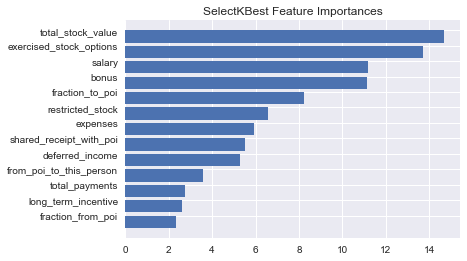

In [23]:
kbest = gnb_grid.best_estimator_.named_steps['selector']

features_array = np.array(features_list)
features_array = np.delete(features_array, 0)
indices = np.argsort(kbest.scores_)[::-1]
k_features = kbest.get_support().sum()

features = []
for i in range(k_features):
    features.append(features_array[indices[i]])

features = features[::-1]
scores = kbest.scores_[indices[range(k_features)]][::-1]

plt.barh(range(k_features), scores)
plt.yticks(np.arange(0.4, k_features), features)
plt.title('SelectKBest Feature Importances')
plt.show()

Abaixo executamos um teste sem as características de engenharia.

In [24]:
# Without the engineered features
# removing the 2 last columns
X_2 = np.delete(X, -1, 1)
X_2 = np.delete(X_2, -1, 1)

evaluate_model(gnb_grid, X_2, y, sss)

Nested f1 score: 0.265476190476
Best parameters: {'selector__k': 10, 'scaler': None}
Mean Accuracy: 0.866666666667
Mean Precision: 0.45
Mean Recall: 0.45
Mean f1: 0.416666666667


# Classificador - KMeans

Pela análise do tester este modelo apresentou precision de 0.26 porém recall: 0.08 e não atende a rubrica do projeto.

In [25]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest()),
        
        ('classifier', KMeans(n_clusters=2, random_state=42))
    ])

param_grid = {
    'scaler': SCALER,
    'selector__k': SELECTOR__K,

}

kmeans_grid = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)

# Avaliar o modelo KMeans
evaluate_model(kmeans_grid, X, y, sss)

# Testando o modelo - tester.py
test_classifier(kmeans_grid.best_estimator_, my_dataset, features_list)

Nested f1 score: 0.0696428571429
Best parameters: {'selector__k': 10, 'scaler': None}
Mean Accuracy: 0.9
Mean Precision: 0.4
Mean Recall: 0.25
Mean f1: 0.3
Pipeline(steps=[('scaler', None), ('selector', SelectKBest(k=10, score_func=<function f_classif at 0x085989B0>)), ('classifier', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0))])
	Accuracy: 0.84620	Precision: 0.26421	Recall: 0.08600	F1: 0.12976	F2: 0.09941
	Total predictions: 15000	True positives:  172	False positives:  479	False negatives: 1828	True negatives: 12521



In [26]:
# uma opção diferente ao test_classifier, mas o resultado obtido é o mesmo 
dump_classifier_and_data(kmeans_grid.best_estimator_, my_dataset, features_list)
main()

Pipeline(steps=[('scaler', None), ('selector', SelectKBest(k=10, score_func=<function f_classif at 0x085989B0>)), ('classifier', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0))])
	Accuracy: 0.84620	Precision: 0.26421	Recall: 0.08600	F1: 0.12976	F2: 0.09941
	Total predictions: 15000	True positives:  172	False positives:  479	False negatives: 1828	True negatives: 12521



# Classificador - AdaBoost

Pela análise do tester este modelo apresentou precision de 0.34 porém recall: 0.26 e não atende a rubrica do projeto.

In [27]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest()),
        # ('reducer', PCA(random_state=42)), - parâmetro relacionado ao PCA que não irei utilizar
        ('classifier', AdaBoostClassifier(random_state=42))
    ])

param_grid = {
    'scaler': SCALER,
    'selector__k': SELECTOR__K,
    # 'reducer__n_components': REDUCER__N_COMPONENTS - parâmetro relacionado ao PCA que não irei utilizar
}

adab_grid = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)

# Avaliar o modelo AdaBoost
evaluate_model(adab_grid, X, y, sss)

# Testando o modelo - tester.py
test_classifier(adab_grid.best_estimator_, my_dataset, features_list)

Nested f1 score: 0.313333333333
Best parameters: {'selector__k': 10, 'scaler': None}
Mean Accuracy: 0.86
Mean Precision: 0.433333333333
Mean Recall: 0.4
Mean f1: 0.393333333333
Pipeline(steps=[('scaler', None), ('selector', SelectKBest(k=10, score_func=<function f_classif at 0x085989B0>)), ('classifier', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42))])
	Accuracy: 0.83487	Precision: 0.34662	Recall: 0.26950	F1: 0.30323	F2: 0.28205
	Total predictions: 15000	True positives:  539	False positives: 1016	False negatives: 1461	True negatives: 11984



# Classificador - Random Forest

Pela análise do tester este modelo apresentou precision de 0.41 porém recall: 0.16 e não atende a rubrica do projeto.

In [28]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest()),
        ('classifier', RandomForestClassifier(max_depth = 5,max_features = 'sqrt',n_estimators = 10, random_state = 42))
    ])

param_grid = {
    'scaler': SCALER,
    'selector__k': SELECTOR__K,

}

rfc_grid = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)

# Avaliar o modelo KMeans
evaluate_model(rfc_grid, X, y, sss)

# Testando o modelo - tester.py
test_classifier(rfc_grid.best_estimator_, my_dataset, features_list)

Nested f1 score: 0.383333333333
Best parameters: {'selector__k': 18, 'scaler': None}
Mean Accuracy: 0.886666666667
Mean Precision: 0.566666666667
Mean Recall: 0.35
Mean f1: 0.413333333333
Pipeline(steps=[('scaler', None), ('selector', SelectKBest(k=18, score_func=<function f_classif at 0x085989B0>)), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))])
	Accuracy: 0.85827	Precision: 0.41923	Recall: 0.16350	F1: 0.23525	F2: 0.18622
	Total predictions: 15000	True positives:  327	False positives:  453	False negatives: 1673	True negatives: 12547



# Teste do P5_poi_id.py

In [29]:
# Importar pasta do projeto final
import os
os.chdir('C:/Users/Lourdes/Downloads/Intro ML/ud120projects/final_project/')

#%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import cPickle as pickle
import seaborn as sns

from time import time
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

sys.path.append("C:/Users/Lourdes/Downloads/Intro ML/ud120projects/tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi', 'salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments',
                 'loan_advances', 'other', 'expenses', 'director_fees', 'total_payments', 
                 'exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 
                 'total_stock_value', 'to_messages', 'from_messages', 'from_this_person_to_poi', 
                 'from_poi_to_this_person', 'shared_receipt_with_poi', 'fraction_from_poi', 'fraction_to_poi']

### Load - dicionário contendo o dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Task 2: Remove outliers
# dic pata dataframe
data_df = pd.DataFrame.from_dict(data_dict, orient='index')

# NaN para numpy 
data_df.replace('NaN', np.nan, inplace = True)

# remover outlier TOTAL
data_df.drop('TOTAL', inplace = True)

# remover outlier LOCKHART EUGENE E
data_dict.pop('LOCKHART EUGENE E', None)
data_df = data_df.drop(['LOCKHART EUGENE E'])

# remover outlier THE TRAVEL AGENCY IN THE PARK
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', None)
data_df = data_df.drop(['THE TRAVEL AGENCY IN THE PARK'])

### Task 3: Create new feature(s)
data_df['fraction_from_poi'] = data_df['from_poi_to_this_person'] / data_df['to_messages']
data_df['fraction_to_poi'] = data_df['from_this_person_to_poi'] / data_df['from_messages']

### Store to my_dataset for easy export below.
# featureFormat expects 'NaN' strings
filled_df = data_df.fillna(value='NaN')

# de volta ao dict
data_dict = filled_df.to_dict(orient='index')

### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
y, X = targetFeatureSplit(data)
X = np.array(X)
y = np.array(y)

### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest()),
        # ('reducer', PCA(random_state=42)),
        ('classifier', GaussianNB())
    ])

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

### hiperparâmetros completos
# SCALER = [None, StandardScaler()]
# SELECTOR__K = [10, 13, 15, 18, 'all']
# REDUCER__N_COMPONENTS = [2, 4, 6, 8, 10]

### Tuned parameters - essa sintonia foi a que o modelo NB escolheu
SCALER = [None]
SELECTOR__K = [13]
# REDUCER__N_COMPONENTS = [2]

param_grid = {
    'scaler': SCALER,
    'selector__k': SELECTOR__K,
    # 'reducer__n_components': REDUCER__N_COMPONENTS
}

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=42) # modifiquei o test_size de 0.2 para 0.1

gnb_grid = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)
gnb_grid.fit(X, y)

clf = gnb_grid.best_estimator_

# Example starting point. Try investigating other evaluation techniques!
cv_accuracy = []
cv_precision = []
cv_recall = []
cv_f1 = []
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    
    cv_accuracy.append(accuracy_score(y_test, pred))
    cv_precision.append(precision_score(y_test, pred))
    cv_recall.append(recall_score(y_test, pred))
    cv_f1.append(f1_score(y_test, pred))
    
print "Mean Accuracy: {}".format(np.mean(cv_accuracy))
print "Mean Precision: {}".format(np.mean(cv_precision))
print "Mean Recall: {}".format(np.mean(cv_recall))
print "Mean f1: {}".format(np.mean(cv_f1))

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

Mean Accuracy: 0.833333333333
Mean Precision: 0.422222222222
Mean Recall: 0.45
Mean f1: 0.386363636364


# Referências bibliográficas

https://classroom.udacity.com/nanodegrees/nd002/parts/0021345409/modules/317428862475460/lessons/2410328539/concepts/24185385370923#

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit

http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

http://scikit-learn.org/stable/modules/tree.html

http://scikit-learn.org/stable/modules/naive_bayes.html

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://en.wikipedia.org/wiki/Precision_and_recall

https://en.wikipedia.org/wiki/Enron_scandal

https://github.com/YannisPap/Identify-Fraud-using-Machine-Learning/blob/master/Enron%20Submission%20Free-Response%20Questions.ipynb

https://github.com/DariaAlekseeva/Enron_Dataset

https://olegleyz.github.io/enron_classifier.html

http://mariofilho.com/as-metricas-mais-populares-para-avaliar-modelos-de-machine-learning/

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

https://github.com/mudspringhiker/enron_poi_id_machine_learning_project/blob/master/classifier_comparison.ipynb

https://www.quora.com/Machine-Learning-How-does-grid-search-work

http://luizschiller.com/enron/

https://github.com/BarbaraJoebstl/da5_fraud_detection/blob/master/final_project/da5_fraud_detection.ipynb